In [2]:
%matplotlib widget

In [3]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load SPS BPM data
Data from first turn for 25 ns beam (closed orbit subtracted)

In [19]:
# Use pandas to import YASP file
injection_trajectory_data = df = pd.read_csv(
    './YASP_injectionTrajectory.txt',
    sep='\s+',
    skiprows=30, skipfooter=218, engine='python',
    names=['name', 'plane', 'beam', 'pos', 'rms', 'sum', 'hw-status', 'status', 'status-tag'],
    index_col='name'
)

closed_orbit_data = df = pd.read_csv(
    './YASP_injectionOrbitReference.txt',
    sep='\s+',
    skiprows=31, skipfooter=218, engine='python',
    names=['name', 'plane', 'beam', 'pos', 'rms', 'sum', 'hw-status', 'status', 'status-tag'],
    index_col='name'
)

# Keep only horizontal BPMs
injection_trajectory_data = injection_trajectory_data[injection_trajectory_data.plane == 'H']
closed_orbit_data = closed_orbit_data[closed_orbit_data.plane == 'H']

assert (injection_trajectory_data.index == closed_orbit_data.index).all()

# Take difference (1st turn - closed orbit)
bpm_meas = pd.DataFrame({'x_meas': 1e-6 * (injection_trajectory_data['pos'].values - closed_orbit_data['pos'].values)},
                        index=[nn.lower() for nn in injection_trajectory_data.index.values])

# Filter out bad readings
bpm_meas['data_ok'] = ((closed_orbit_data['status-tag'] == 'OK') & (injection_trajectory_data['status-tag'] == 'OK')).values
bpm_meas.loc['bph.42008', 'data_ok'] = False
bpm_meas = bpm_meas[bpm_meas['data_ok']]

# Start from injection point
bpm_meas = bpm_meas.loc['bph.12008':, :]

In [20]:
bpm_meas.iloc[55, :]

x_meas    -0.001794
data_ok        True
Name: bph.42008, dtype: object

In [21]:
# Look at data for one BPM
bpm_meas.loc['bph.63208', 'x_meas']

0.0007229

Text(0.5, 0, 'Monitor number')

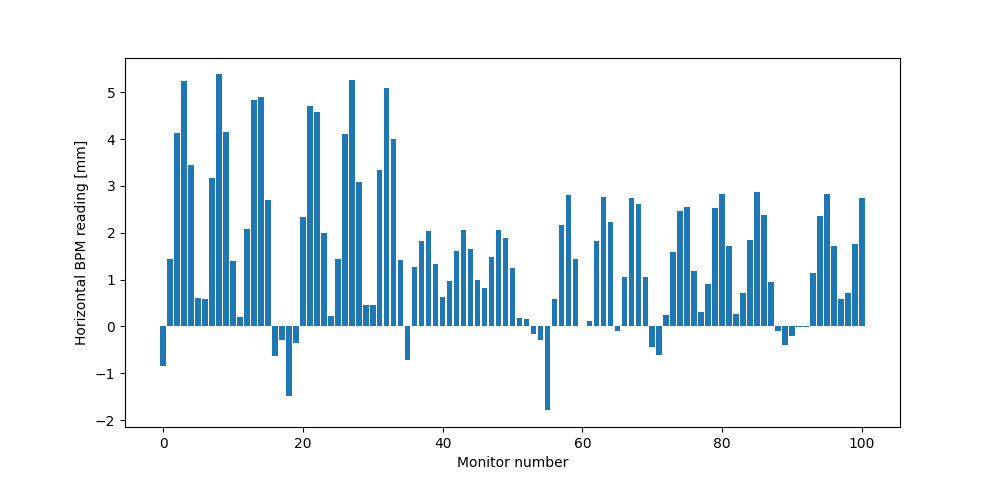

In [22]:
# Plot data (excursions observed to be larger in the first two sectors)
plt.figure(figsize=(10, 4.8))
plt.bar(height=bpm_meas.x_meas*1e3, x=range(len(bpm_meas)))
plt.ylabel('Horizontal BPM reading [mm]')
plt.xlabel('Monitor number')

### Load Xsuite model of the SPS

In [23]:
# Load lattice
env = xt.load_madx_lattice('acc-models-sps/sps.seq')
sps = env['sps']

# Load optics
sps.vars.load_madx('acc-models-sps/strengths/lhc_q20.str')

# Set reference patricle
sps.particle_ref = xt.Particles(mass0=xt.PROTON_MASS_EV, q0=1, p0c=26e9)

In [24]:
# Setup RF (200 MHz and 800 MHz)
sps.set('actcse.31632', voltage=4.5e6, lag=180., frequency=200e6)
sps.set('acl.31735', voltage=0.45e6, lag=0., frequency=800e6)

In [25]:
# Twiss to check the model
tw = sps.twiss()
print(f'qx={tw.qx:.4f}, qy={tw.qy:.4f}, qs={tw.qs:.4f}')

qx=20.1300, qy=20.1800, qs=0.0117


### Compute first turn trajectory

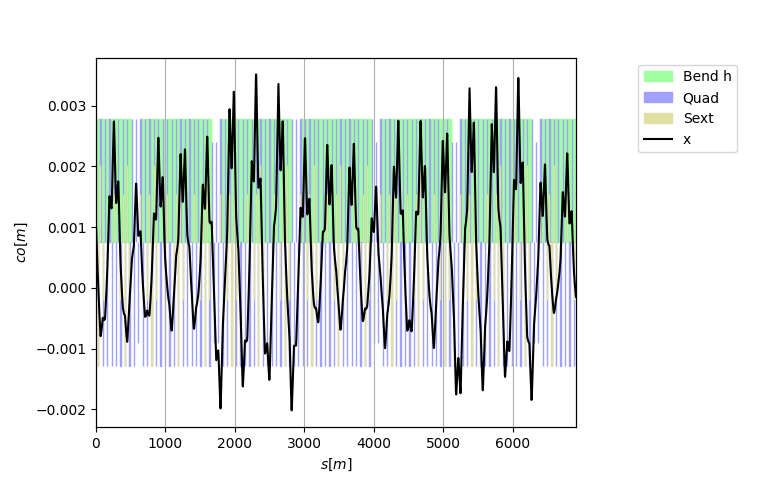

In [26]:
# Use variables to define the initial conditions
sps['x_inj'] = 1e-3
sps['px_inj'] = 0.
sps['delta_inj'] = 2e-4
sps['zeta_inj'] = 0.

tw_turn_1 = sps.twiss(
    betx=1, bety=1,
    x=sps['x_inj'], px=sps['px_inj'],
    delta=sps['delta_inj'], zeta=sps['zeta_inj'])

tw_turn_1.plot('x')

### Can we find initial conditions for which the model reproduces the measured trajectory?

We can use the Xsuite optimizer to seach for such conditions

In [27]:
# Define an action computing the first tune trajectory
@xt.Action
def tw_1st_turn():
    return sps.twiss(
        betx=1, bety=1,
        x=sps['x_inj'], px=sps['px_inj'],
        delta=sps['delta_inj'], zeta=sps['zeta_inj'])

In [28]:
# The action can be used to define an optimization target, for example:
target_bph_63608 = tw_1st_turn.target('x', 1e-3, at='bph.63608')

In [33]:
# We can use a python for loop to create targets aiming at maching the measurements at all BPMs
targets = []
for nn in bpm_meas.index:
    targets.append(tw_1st_turn.target('x', bpm_meas.loc[nn, 'x_meas'], at=nn))
targets

[Target(('x', 'bph.12008'), val=-0.0008528, tol=None, weight=None),
 Target(('x', 'bph.12208'), val=0.0014424, tol=None, weight=None),
 Target(('x', 'bph.12408'), val=0.0041292, tol=None, weight=None),
 Target(('x', 'bph.12608'), val=0.0052441, tol=None, weight=None),
 Target(('x', 'bph.12808'), val=0.0034377, tol=None, weight=None),
 Target(('x', 'bph.13008'), val=0.0006, tol=None, weight=None),
 Target(('x', 'bph.13208'), val=0.000576, tol=None, weight=None),
 Target(('x', 'bph.13408'), val=0.0031604, tol=None, weight=None),
 Target(('x', 'bph.13608'), val=0.0053838, tol=None, weight=None),
 Target(('x', 'bph.20208'), val=0.0041483, tol=None, weight=None),
 Target(('x', 'bph.20408'), val=0.0014072, tol=None, weight=None),
 Target(('x', 'bph.20608'), val=0.0001966, tol=None, weight=None),
 Target(('x', 'bph.20808'), val=0.0020856, tol=None, weight=None),
 Target(('x', 'bph.21008'), val=0.0048304, tol=None, weight=None),
 Target(('x', 'bph.21208'), val=0.004902, tol=None, weight=None),

In [34]:
# Build an optimizer object
opt = sps.match(
    solve=False,
    vary=[
        xt.Vary('x_inj', step=1e-4),
        xt.Vary('px_inj', step=1e-6),
        xt.Vary('delta_inj', step=1e-5),
        xt.Vary('zeta_inj', step=1e-3),
    ],
    targets=targets
)

In [35]:
# Search solution
opt.step(10)         # Jacobian solver
opt.run_simplex(100) # Nelder-Mead solver

                                             
Optimize - start penalty: 0.18          
Matching: model call n. 87               
Optimize - end penalty:  0.0436884
                                             
Optimize - start penalty: 0.04369        
Matching: model call n. 265               1036              
Optimize - end penalty:  0.0321938


In [36]:
# Inspect solution
opt.vary_status()

Vary status:                 
id state tag met name      lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  x_inj     None           0.00380689 None                0.001        0.0001             1
1  ON        OK  px_inj    None          6.71439e-05 None                    0         1e-06             1
2  ON        OK  delta_inj None          0.000557167 None               0.0002         1e-05             1
3  ON        OK  zeta_inj  None            -0.315147 None                    0         0.001             1


### Compare model against measurements

In [37]:
tw_turn_1_after_optim = tw_1st_turn()

In [39]:
# Extract BPMs only
tw_turn_1_opt_at_bpms = tw_turn_1_after_optim.rows[bpm_meas.index]

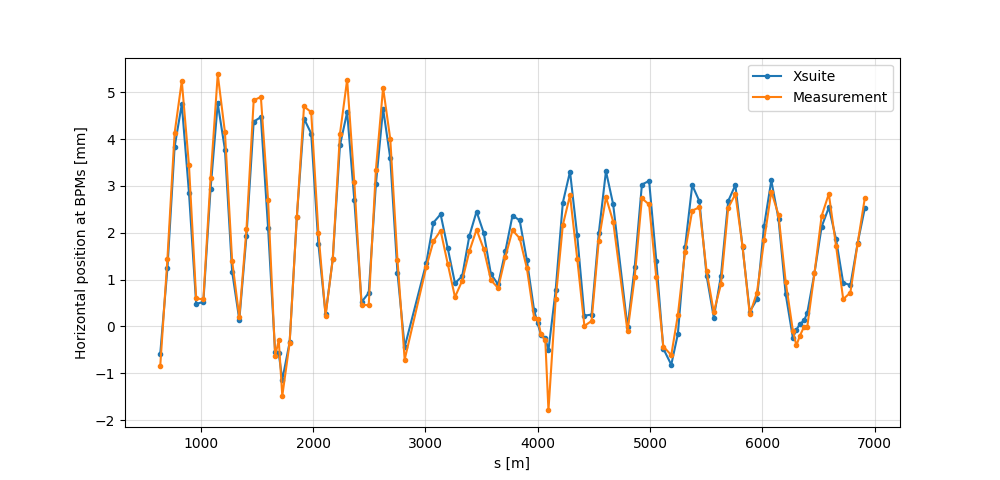

In [40]:
# Plot
plt.figure(figsize=(10, 4.8))
plt.plot(tw_turn_1_opt_at_bpms.s, tw_turn_1_opt_at_bpms.x * 1e3, '.-', label='Xsuite')
plt.plot(tw_turn_1_opt_at_bpms.s, bpm_meas['x_meas'] * 1e3, '.-', label='Measurement')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('Horizontal position at BPMs [mm]')
plt.grid(True, alpha=0.4)